In [2]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
from time import time

import pyro
import torch
import pyro.optim as optim
from pyro.infer import SVI, JitTrace_ELBO, Predictive
from pyro.contrib.autoguide import AutoDiagonalNormal

from data_proc import load_raw_data, processData, transform_data, split_and_prep_data
from post_model import post_model, post_guide
from model_utils import get_y_pred, get_type_only_y_pred, get_s_means, get_r_means, get_t_means, get_mean_y_pred
from inference import run_svi, plot_losses
from evaluation import plot_predictions, get_samples, gather_az_inference_data, plot_pp_pdf, plot_pp_cdf, plot_ppc, plot_residuals, MAE, MSE, R2, get_quantiles, plot_pp_hdi


pyro.enable_validation(True)

# Expectations

# Data

First, we load the Reddit datasets

In [3]:
comments, corrections, news = load_raw_data()

### Process and Unpack Data

In [4]:
COMMENTS_ONLY = True

In [5]:
data_tuple, lookup_tuple, label_tuple = processData(news + corrections, comments, comments_only=COMMENTS_ONLY, minutes=60)

In [6]:
original_p_data, t_data, s_data, r_data, y = data_tuple
p_types, p_stories, p_subreddits = lookup_tuple
countries, authors, story_claim_titles, subreddits = label_tuple

p_data variables (in order):

0. bias
1. num_comments in first _ mins
2. num_subscribers at time of submission

types

0. Real News
1. Fake News
2. Correction on Real News
3. Correction on Fake News

t_data variables (in order):

0. bias
1. Real News Dummy
2. Fake News Dummy
3. Correction on Real News Dummy
4. Correction on Fake News Dummy

s_data variables:

0. bias
1. country dummies (multiple may be "on")
2. author dummies

r_data variables:

0. bias
1. subreddit dummies

In [12]:
real_news_posts = y[p_types==0]

In [16]:
fake_news_posts = y[p_types==1]

In [36]:
real_news_correction = y[p_types==2]

In [37]:
fake_news_correction = y[p_types==3]

In [34]:
real_news_posts.shape

(955,)

In [35]:
fake_news_posts.shape

(3741,)

In [28]:
np.mean(real_news_posts)

23.01151832460733

In [27]:
np.mean(fake_news_posts)

12.124031007751938

In [38]:
np.mean(real_news_correction)

13.499045346062053

In [39]:
np.mean(fake_news_correction)

20.778867273297774

In [44]:
np.mean(real_news_posts[real_news_posts > 0])

68.675

In [45]:
np.mean(fake_news_posts[fake_news_posts > 0])

30.481182795698924

In [46]:
np.mean(real_news_correction[real_news_correction > 0])

38.01142473118279

In [47]:
np.mean(fake_news_correction[fake_news_correction > 0])

46.03562738964199

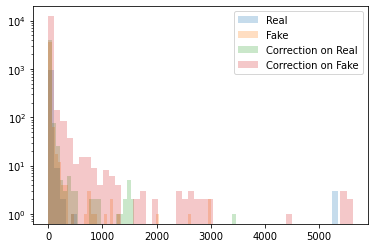

In [50]:
plt.hist(real_news_posts, alpha=0.25, label="Real", bins=50)
plt.hist(fake_news_posts, alpha=0.25, label="Fake", bins=50)
plt.hist(real_news_correction, alpha=0.25, label="Correction on Real", bins=50)
plt.hist(fake_news_correction, alpha=0.25, label="Correction on Fake", bins=50)
plt.yscale("log")
plt.legend()
plt.show()

In [102]:
data = [[real_news_posts, fake_news_posts], [real_news_correction, fake_news_correction]]
labels = [["Real News", "Fake News"], ["Correction on Real", "Correction on Fake"]]
colors = [["tab:green", "tab:red"], ["tab:green", "tab:red"]]

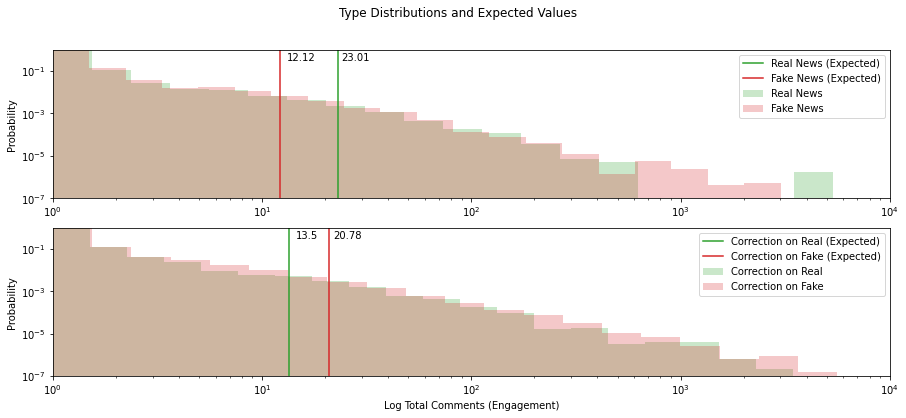

In [146]:
plt.figure(figsize=(15, 6))
for i, (data_list, label_list, color_list) in enumerate(zip(data, labels, colors)):
    
    plt.subplot(2, 1, i+1)
    
    for d, l, c in zip(data_list, label_list, color_list):
        hist, bins = np.histogram(d + 1, bins=20)
        logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
        plt.hist(d + 1, alpha=0.25, label=l, bins=logbins, density=True, color=c)
        plt.xscale('log')
#         plt.xlim(0, 6000)
        plt.ylim(1e-7, 1)
        plt.xlim(1, 1e4)
        plt.axvline(d.mean(), label=f"{l} (Expected)", c=c)
        plt.text(np.exp(np.log(d.mean() + 1)), 0.3, f"{np.round(d.mean(), 2)}")
#         plt.axvline(d[d > 0].mean(), label=f"{l} (Expected (for > 0))", c=c)
    
    plt.xscale("log")
    plt.yscale("log")
    plt.ylabel("Probability")
    plt.legend()
plt.suptitle("Type Distributions and Expected Values")
plt.xlabel("Log Total Comments (Engagement)")
plt.show()